# 📚 Import necessary libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# ---- Filter ALL Python warnings ----

warnings.filterwarnings("ignore")

# ---- Filter specific common warning categories ----

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---- Filter pandas warnings specifically ----

warnings.filterwarnings("ignore", module="pandas")
warnings.filterwarnings("ignore", message=".*CUDA.*")
warnings.filterwarnings("ignore", message=".*GPU.*")
warnings.filterwarnings("ignore", message=".*cuda.*")
warnings.filterwarnings("ignore", message=".*device.*")

# 📂 Read Train and Test datasets

In [47]:
df= pd.read_csv("/kaggle/input/titanic/train.csv")

test = pd.read_csv("/kaggle/input/titanic/test.csv")

# 📊 See Columns of the dataset

In [48]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# 🧹 Remove Duplicates

In [49]:
print(df.duplicated().sum())

df.drop_duplicates()

0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 🧩 Feature Engineer Title column

In [50]:
# ---- Extract titles ----

df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# ---- Map titles to Mr, Miss, Mrs, Master ----

title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Miss": "Miss",

    "Mme": "Mrs",
    "Mrs": "Mrs",
    "Countess": "Mrs",
    "Lady": "Mrs",

    "Mr": "Mr",
    "Dr": "Mr",
    "Rev": "Mr",
    "Major": "Mr",
    "Col": "Mr",
    "Capt": "Mr",
    "Sir": "Mr",
    "Don": "Mr",
    "Jonkheer": "Mr",

    "Master": "Master"
}

df["Title"] = df["Title"].map(title_map).fillna("Mr")
test["Title"] = test["Title"].map(title_map).fillna("Mr")
df["Title"].value_counts()

Title
Mr        538
Miss      185
Mrs       128
Master     40
Name: count, dtype: int64

# 🧩 Feature Engineer Family Size Column

In [51]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df.drop(columns=["SibSp","Parch"],inplace=True)
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test.drop(columns=["SibSp","Parch"],inplace=True)
test['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# 🔍 Impute missing Age values by Title Groups

In [52]:
title_ages = df.groupby('Title')['Age'].median()

df['Age'] = df.apply(lambda row: title_ages[row['Title']] if pd.isnull(row['Age']) else row['Age'], axis=1)

test['Age'] = df.apply(lambda row: title_ages[row['Title']] if pd.isnull(row['Age']) else row['Age'], axis=1)


# 🧩 Categorize Age into 5 different groups

In [53]:
df['Child'] = df['Age'].between(0, 12.99).astype(int)
df['Teen'] = df['Age'].between(13, 19.99).astype(int)
df['Young_Adult'] = df['Age'].between(20, 35.99).astype(int)
df['Adult'] = df['Age'].between(36, 60.99).astype(int)
df['Senior'] = (df['Age'] >= 61).astype(int)

test['Child'] = df['Age'].between(0, 12.99).astype(int)
test['Teen'] = df['Age'].between(13, 19.99).astype(int)
test['Young_Adult'] = df['Age'].between(20, 35.99).astype(int)
test['Adult'] = df['Age'].between(36, 60.99).astype(int)
test['Senior'] = (df['Age'] >= 61).astype(int)

# 📝 Display info and first 10 rows

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Embarked     889 non-null    object 
 10  Title        891 non-null    object 
 11  FamilySize   891 non-null    int64  
 12  IsAlone      891 non-null    int64  
 13  Child        891 non-null    int64  
 14  Teen         891 non-null    int64  
 15  Young_Adult  891 non-null    int64  
 16  Adult        891 non-null    int64  
 17  Senior       891 non-null    int64  
dtypes: float64(2), int64(10), object(6)
memory usage: 

In [55]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Child,Teen,Young_Adult,Adult,Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,Mr,2,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,Mrs,2,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,Mrs,2,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,Mr,1,1,0,0,1,0,0
5,6,0,3,"Moran, Mr. James",male,30.0,330877,8.4583,NaN,Q,Mr,1,1,0,0,1,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,17463,51.8625,E46,S,Mr,1,1,0,0,0,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,349909,21.0750,NaN,S,Master,5,0,1,0,0,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,347742,11.1333,NaN,S,Mrs,3,0,0,0,1,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,237736,30.0708,NaN,C,Mrs,2,0,0,1,0,0,0


# 🛳️ Survival Counts in general

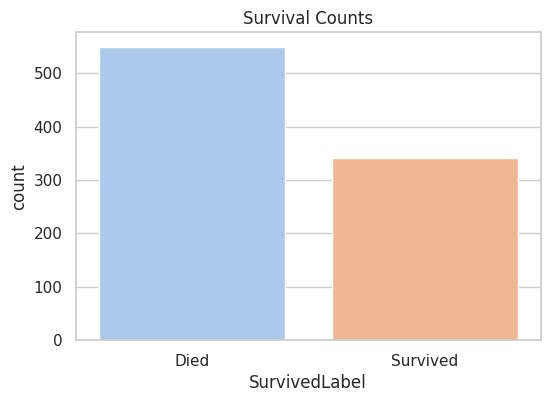

In [56]:
sns.set(style="whitegrid")
df["SurvivedLabel"] = df["Survived"].map({0: "Died", 1: "Survived"})
plt.figure(figsize=(6,4))
sns.countplot(x="SurvivedLabel", data=df, palette="pastel")
plt.title("Survival Counts")
plt.show()

# 🚻 Survival Counts by Sex

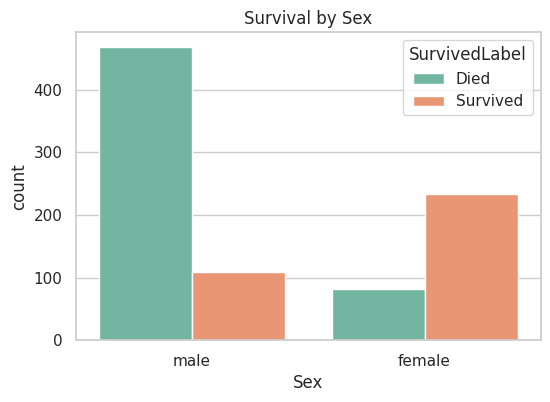

In [57]:
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", hue="SurvivedLabel", data=df, palette="Set2")
plt.title("Survival by Sex")
plt.show()

# 🎩 Survival by Passenger Class

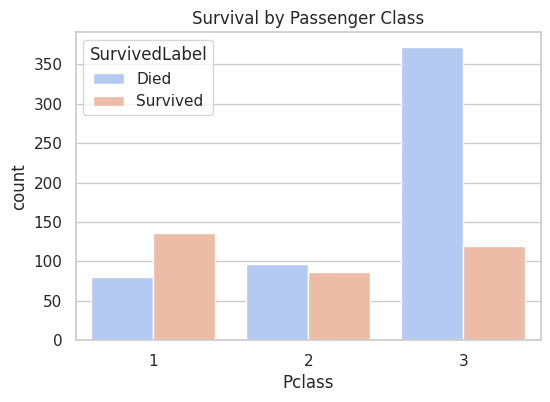

In [58]:
plt.figure(figsize=(6,4))
sns.countplot(x="Pclass", hue="SurvivedLabel", data=df, palette="coolwarm")
plt.title("Survival by Passenger Class")
plt.show()

# 👨‍👩‍👧‍👦 Survival by Family size

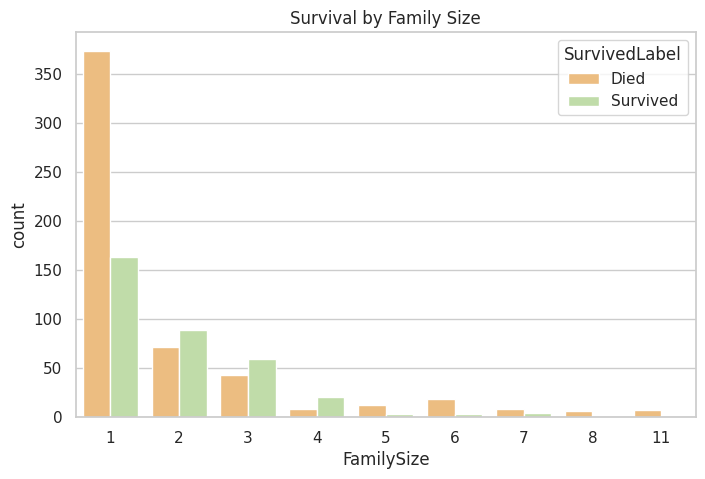

In [59]:
plt.figure(figsize=(8,5))
sns.countplot(x="FamilySize", hue="SurvivedLabel", data=df, palette="Spectral")
plt.title("Survival by Family Size")
plt.show()

# 👶 Survival by Age groups

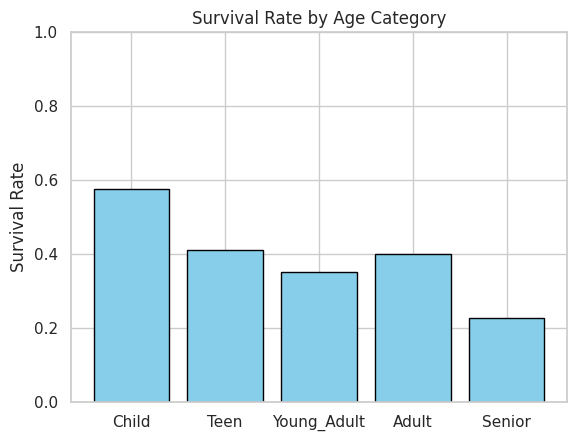

In [60]:
age_groups = ["Child", "Teen", "Young_Adult", "Adult", "Senior"]

survival_rates = []
for group in age_groups:
    survival_rates.append(df[df[group] == 1]["Survived"].mean())

plt.bar(age_groups, survival_rates, color="skyblue", edgecolor="black")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Age Category")
plt.ylim(0, 1)
plt.show()

# 🛠️ Encode Sex Column

In [61]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

# 🧹 Drop Unnecessary columns

In [62]:
df.drop(columns=["PassengerId","Name","Ticket","Cabin","Title","Age","SurvivedLabel"],axis=1, inplace=True)

test.drop(columns=["Name","Ticket","Cabin","Title","Age"],axis=1, inplace=True)

# 🔍 Fill missing values in Fare column in the test dataset

In [63]:
# ---- Fill null values in Fare ----

test["Fare"]=test["Fare"].fillna(test["Fare"].median())                 

# 🧱 Features

In [64]:
# ---- Features ----

features=['Pclass', 'Sex', 'Fare', 'FamilySize', 'IsAlone', 'Child','Teen', 'Young_Adult', 'Adult', 'Senior']

x = df[features]
y = df["Survived"]

# 🏗️ Model Archeticture

In [65]:
# ---- Base models ----

gb = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.01, max_depth=3, 
    min_samples_split=2, min_samples_leaf=5, 
    subsample=1.0, max_features='sqrt', random_state=214
)

xgb = XGBClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.01, 
    subsample=0.8, colsample_bytree=0.6, gamma=1, min_child_weight=1, 
    scale_pos_weight=1, random_state=244, device="cuda", 
    use_label_encoder=False, eval_metric="logloss"
)

# ---- Ensemble ----

ensemble = VotingClassifier(
    estimators=[("gb", gb), ("xgb", xgb)],
    voting="soft", weights=[2, 1], n_jobs=-1
)

# ---- Train/Validation split ----

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=134, stratify=y)

ensemble.fit(x_train, y_train)
y_pred = ensemble.predict(x_val)
val_acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# ---- Cross-validation ----

cv_scores = cross_val_score(ensemble, x, y, cv=4, scoring="accuracy", n_jobs=-1)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [20:24:49] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
[20:24:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[20:24:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


Validation Accuracy: 0.8603
Cross-Validation Accuracy: 0.8081 ± 0.0326


[20:24:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[20:24:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


# 🤖 Model Training and Prediction

In [66]:
# ---- Train on full training data ----

ensemble.fit(x, y)

# ---- Predict on test ----

x_test = test[features]
test["Survived"] = ensemble.predict(x_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [20:24:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


# 💾 Saving Model

In [67]:
# ---- Build Kaggle submission ----

submission = test[["PassengerId", "Survived"]]
submission.to_csv("FinalSubmission.csv", index=False)

print("Submission file saved as Finalsubmission.csv")

# ---- Save Model ----

joblib.dump(ensemble, "titanic_ensemble_model.pkl")

Submission file saved as Finalsubmission.csv


['titanic_ensemble_model.pkl']